In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import datetime
import requests
import sys
import os
import json
import time
import re

In [2]:
headers0 = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.11; rv:48.0) Gecko/20100101 Firefox/48.0',
    'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    'accept-language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
    'keep-alive': 'keep-alive',
    'cache-control': 'max-age=0',
}

Подключение.

In [3]:
URL = 'http://admining.hadoop1.corp.mail.ru/login/'
logn = 'a.tleubayev'
passwd = ''
client = requests.session()

client.get(URL)
csrftoken = client.cookies['csrftoken']

login_data = dict(username=logn, password=passwd,
                  csrfmiddlewaretoken=csrftoken, next='/')
r = client.post(URL, data=login_data, headers=dict(Referer=URL))

if len(r.content) < 5000:
    print('Неверно введен логин или пароль')
    exit(1)

Скачиваем дерево.

In [4]:
categoryRootName = u'Досуг'
categoryRootId   = 405

In [5]:
url = 'http://admining.hadoop1.corp.mail.ru/api/load_tree/'
try:
    page = requests.get(url, timeout=10)
except requests.exceptions.Timeout:
    print('Ошибка подключения к admining.hadoop1.corp.mail.ru, проверьте подключение к VPN.')
    exit(1)
soup = BeautifulSoup(page.content, 'html.parser')
tree = json.loads(str(soup))

In [6]:
def getDataId(tree, idCategory, flag=False):
    dataId = {}
    if tree['id'] == idCategory or flag:
        dataId[tree['id']] = tree['text']
        flag = True
        
    if tree['children'] != None:
        for i in tree['children']:
#             print(dataId)
            dataId.update(getDataId(i, idCategory, flag))
            
    return dataId

In [7]:
dataId = {}
for i in tree:
    dataId.update(getDataId(i, categoryRootId))

In [8]:
dataId.keys()

dict_keys([405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 456, 419, 420, 421, 422, 838, 839, 840, 841, 842, 843, 884, 423, 424, 425, 426, 427, 1497, 428, 429, 430, 997, 1028, 1029, 1030, 1031, 1046, 1144, 1121, 1127, 1261, 1262, 1334, 1430])

In [9]:
def getDataUrls(dataId):
    urls = []
    for categoryId in dataId:
        data = client.get('http://admining.hadoop1.corp.mail.ru/load_patterns/{}/'.format(categoryId)).content
        data_json = json.loads(data.decode())
        urls.extend([[i.split(' ')[0], categoryId] for i in data_json[u'patterns'].split('\n')])

    urls = np.array(urls)
    table = pd.DataFrame({'urls': urls.T[0], 'categoryId': urls.T[1]})
    table = pd.get_dummies(table, columns=['categoryId'])
    table = table.groupby('urls').sum()
    
    return table.index, table.values

In [10]:
dataUrls, dataCategories = getDataUrls(dataId)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
trainUrls, testUrls, trainCategory, testCategory = \
    train_test_split(dataUrls, dataCategories, test_size=0.2)

In [13]:
np.save('data/trainUrls.npy', trainUrls)
np.save('data/trainCategory.npy', trainCategory)
np.save('data/testUrls.npy', testUrls)
np.save('data/testCategory.npy', testCategory)

In [3]:
from multiprocessing.pool import ThreadPool

In [4]:
class LoggingPool(ThreadPool):
    def apply_async(self, func, args=(), kwds={}, callback=None):
        return ThreadPool.apply_async(self, LogExceptions(func), args, kwds, callback)

In [5]:
trainUrls = np.load('data/trainUrls.npy')
trainCategory = np.load('data/trainCategory.npy')
testUrls = np.load('data/testUrls.npy')
testCategory = np.load('data/testCategory.npy')

# trainTextsToken = np.load('data/trainTextsToken.npy').tolist()
# testTextsToken = np.load('data/testTextsToken.npy').tolist()

In [10]:
def getText(domain):
    " Cкачать текст с главной страницы домена domain "
    try:    
        page = requests.get('http://'+domain, headers=headers0, timeout=100)
        soup = BeautifulSoup(page.content)

        for script in soup(["script", "style"]):
            script.extract()

        text = soup.get_text()
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text = '\n'.join(chunk for chunk in chunks if chunk)
        
    except:
        text = 'NOTEXT'
    return text

In [11]:
pool = LoggingPool(processes=64)

In [12]:
%%time
trainTexts = pool.map(getText, trainUrls)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 884 of the file /home/adil/.pyenv/versions/3.6.1/lib/python3.6/threading.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


CPU times: user 15min 29s, sys: 41 s, total: 16min 10s
Wall time: 15min 21s


In [13]:
%%time
testTexts = pool.map(getText, testUrls)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 884 of the file /home/adil/.pyenv/versions/3.6.1/lib/python3.6/threading.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


CPU times: user 4min 8s, sys: 13.1 s, total: 4min 21s
Wall time: 4min 54s


In [14]:
import pymorphy2
import re

re_extract_words = re.compile('[^а-яёa-z0-9]')
re_repeat_spaces = re.compile('[ ]+')

morph = pymorphy2.MorphAnalyzer()


def morph_tokenizer(text):
    ext_text = re_extract_words.sub (u' ', text.lower())
    words = re_repeat_spaces.sub (u' ', ext_text)
    words = words.split (u' ')
    
    norms = [ morph.parse (w)[0].normal_form  for w in words  if (len (w) > 1) ]
    return norms

In [15]:
%%time
trainTextsToken = pool.map(morph_tokenizer, trainTexts)

CPU times: user 13min 36s, sys: 41.1 s, total: 14min 17s
Wall time: 13min 14s


In [16]:
%%time
testTextsToken = pool.map(morph_tokenizer, testTexts)

CPU times: user 3min 20s, sys: 10.6 s, total: 3min 30s
Wall time: 3min 15s


In [17]:
np.save('data/trainTextsTokenNew.npy', trainTextsToken)
np.save('data/testTextsTokenNew.npy', testTextsToken)

# Признаки

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier, NearestNeighbors
from sklearn.cross_validation import cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import RidgeClassifier, LinearRegression, LogisticRegression

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
labels = [405, 406, 407, 408, 409, 410, 411, 412, 413, 414,\
          415, 416, 417, 418, 456, 419, 420, 421, 422, 838,\
          839, 840, 841, 842, 843, 884, 423, 424, 425, 426,\
          427, 1497, 428, 429, 430, 997, 1028, 1029, 1030,\
          1031, 1046, 1144, 1121, 1127, 1261, 1262, 1334, 1430]

In [5]:
# delWords = ['div', 'js', 'td', 'document', 'color', 'url', 'span', 'li', 'true', 'screen', 'text',\
#             'type', 'com', 'jpg', 'group', 'value', 'block', 'vc', 'img', 'style', 'right', 'width',\
#             'border', 'new', 'src', 'content', 'http', 'hover', 'font', 'this', 'none', 'ru', 'background',\
#             'false', 'var', 'return', 'null', 'menu', 'if', 'left', 'height', 'margin', 'title', 'https',\
#             'important', 'image', 'function', 'padding', 'bottom', 'class', 'name', 'param', 'card', 'size',\
#             'window', 'top', 'script', 'push', 'data', 'ul', 'href', 'id', 'display', 'location', 'css', 'async',\
#             'tta', 'all', 'body', 'png', 'escape', 'html', 'parentnode', 'input', 'index', 'button', 'jquery',\
#             'opera', 'event', 'position', 'rgba', 'link', 'ga', 'main', 'metrika', 'btn', 'show', 'container',\
#             'form', 'header', 'center', 'javascript', 'webkit', 'search', 'typeof', 'box', 'www', 'click',\
#             'radius', 'length', 'getelementsbytagname', 'date', 'no', 'insertbefore', 'before', 'colordepth',\
#             'else', 'icon', 'write', 'post', 'for', 'wp', 'net', 'in', 'active', 'code', 'auto', 'item', 'align',\
#             'widget', 'createelement', 'cat', 'bx', 'place',\
delWords = ['а', 'без', 'в', 'во', 'на', 'с', 'со', 'до', 'для', 'за', 'из', 'из-за', 'к', 'ко', 'между', 'у',\
            'над', 'надо', 'без', 'не', 'о', 'об', 'обо', 'от', 'перед', 'по', 'под', 'подо', 'после', 'пред',\
            'при', 'про',\
            'чей', 'себя', 'сколько', 'любой', 'самый', 'что', 'некого', 'он', 'она', 'где', 'весь', 'я', 'ты',\
            'сам', 'какой', 'зачем', 'никто', 'наш', 'незачем', 'мы', 'свой', 'кто-то', 'другой', 'их',\
            'никакой', 'который', 'ничей', 'нечто', 'они', 'каковой', 'вы', 'такой', 'ничто', 'какой-либо',\
            'когда', 'этот', 'каждый', 'некто', 'тот', 'каков', 'всякий', 'нечего', 'ваш', 'таков', 'столько',\
            'что-нибудь', 'сей', 'иной', 'несколько', 'его', 'твой', 'оно', 'её', 'некоторый', 'мой', 'откуда',\
            'кто'
           ]

In [6]:
trainUrls = np.load('data/trainUrls.npy')
trainCategory = np.load('data/trainCategory.npy')
testUrls = np.load('data/testUrls.npy')
testCategory = np.load('data/testCategory.npy')

trainTextsToken = np.load('data/trainTextsTokenNew.npy').tolist()
testTextsToken = np.load('data/testTextsTokenNew.npy').tolist()

In [7]:
trainCategory[trainCategory != 0] = 1
testCategory[testCategory != 0] = 1

### Tfidf

In [8]:
trainTexts = [' '.join(i) for i in trainTextsToken]
testTexts = [' '.join(i) for i in testTextsToken]

In [9]:
tfidfTransformer = TfidfVectorizer()
trainFeatures  = tfidfTransformer.fit_transform(trainTexts)
testFeatures = tfidfTransformer.transform(testTexts)

### Filter+Tfidf

In [45]:
trainTextsFilter = [' '.join([j if j not in delWords 
                              and not bool(re.search(r'\d', j))
                              and bool(re.search(r'[а-я]', j))
                              else '' for j in i]) for i in trainTextsToken]
testTextsFilter = [' '.join([j if j not in delWords 
                              and not bool(re.search(r'\d', j)) 
                              and bool(re.search(r'[а-я]', j))
                              else '' for j in i]) for i in testTextsToken]

In [46]:
tfidfTransformer = TfidfVectorizer()
trainFeatures  = tfidfTransformer.fit_transform(trainTextsFilter)
testFeatures = tfidfTransformer.transform(testTextsFilter)

### One class

In [12]:
_time = time.time()
clf = LogisticRegression(penalty='l1', n_jobs=5)
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  25.61989712715149
accuracy_score:  0.667414050822


l2:
Fit time:  27.65433645248413
accuracy_score:  0.67264573991

l1:
Fit time:  25.61989712715149
accuracy_score:  0.667414050822

In [47]:
_time = time.time()
clf = RidgeClassifier()
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  27.7691593170166
accuracy_score:  0.712257100149


In [10]:
_time = time.time()
clf = NearestCentroid()
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  0.21486854553222656
accuracy_score:  0.659940209268


In [49]:
_time = time.time()
clf = KNeighborsClassifier()
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  0.012741804122924805
accuracy_score:  0.313153961136


In [10]:
_time = time.time()
clf = KNeighborsClassifier(algorithm='brute', metric='cosine')
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  0.010978937149047852
accuracy_score:  0.669656203288


In [51]:
_time = time.time()
clf = SVC()
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  69.89844346046448
accuracy_score:  0.111360239163


In [52]:
_time = time.time()
clf = SVC(gamma=0.5)
clf.fit(trainFeatures, trainCategory.argmax(axis=1))
print('Fit time: ', time.time() - _time)
predict = clf.predict(testFeatures)
print('accuracy_score: ', accuracy_score(testCategory.argmax(axis=1), predict))

Fit time:  91.82887244224548
accuracy_score:  0.674140508221


### Multi class

In [11]:
_time = time.time()
clf = OneVsRestClassifier(LogisticRegression(C=1e9), n_jobs=5)
clf.fit(trainFeatures, trainCategory)
print('Fit time: ', time.time() - _time)

Fit time:  83.77743864059448


In [12]:
predict = clf.predict(testFeatures)

In [40]:
sum(testCategory.sum(axis=1) > 1) + sum(trainCategory.sum(axis=1) > 1)

274

In [47]:
pr = predict[testCategory.sum(axis=1) == 1]
ts = testCategory[testCategory.sum(axis=1) == 1]
ans = testUrls[testCategory.sum(axis=1) == 1]

In [57]:
pr[pr.sum(axis=1) > 1][0] == 1

array([False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [48]:
ans[pr.sum(axis=1) > 1]

array(['crisscross.at.ua', 'craftsoap.ru', 'teatrbilet.ru',
       'art-tvorchestvo.spb.ru', 'vdk.colornumbers.ru', 'brrc.ru',
       'technohobby66.ru', 'rostovopera.ru', 'my-basket.ru',
       'room-cafe.ru', 'astrokammerton.mybb.ru', 'schema.wwwreferats.net',
       'markshtadt74.ru', 'udmurt.media', 'ticketmix.ru', 'ufa.biglion.ru',
       'tourlib.net', 'msk-bilet.ru', 'biletservis.ru', 'bravo.ru',
       'questhunt.ru', 'strazek.ru', 'vedicsoft.ru', 'ra6foo.qrz.ru',
       'rc-go.by', 'kids-in-trips.ru', 'magnumshop.net',
       'live-football.ru', 'kartinka74.ru', 'rc-x.ru',
       'jazz-cafe.tomsk.ru', 'ytka.ru', 'other.nnm.me', 'webclubnicka.ru',
       'sim-sim.ru', 'nk1.ru', 'radioair.ru', 'bg.ru',
       'xn--b1acdcqi5ci.xn--p1ai', 'quadrozone.ru'], dtype=object)

In [34]:
p2 = pr[pr.sum(axis=1) != 0]
t2 = ts[pr.sum(axis=1) != 0]

In [37]:
ans = 0
for i in range(p2.shape[0]):
    print(sum(t2[i]), f1_score(t2[i], p2[i]))
    ans += f1_score(t2[i], p2[i])
ans /= p2.shape[0]
print(ans)

2 0.0
2 1.0
2 0.5
2 1.0
5 0.333333333333
2 1.0
2 1.0
2 0.666666666667
2 0.0
2 1.0
2 1.0
2 1.0
2 0.0
2 0.666666666667
3 1.0
2 1.0
2 1.0
6 0.5
2 1.0
2 1.0
2 1.0
7 0.25
9 0.2
2 0.666666666667
4 0.4
2 0.666666666667
2 1.0
2 1.0
2 0.666666666667
2 0.666666666667
2 1.0
2 0.0
2 0.666666666667
2 1.0
2 1.0
2 1.0
2 1.0
0.725675675676


In [23]:
ans = 0
for i in range(predict.shape[0]):
    ans += f1_score(testCategory[i], predict[i])
ans /= predict.shape[0]
print(ans)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.592314399601


In [42]:
predict = clf.predict_proba(testFeatures)
mas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for j in range(len(mas)):
    pred = np.zeros(predict.shape)
    pred[predict >= mas[j]] = 1

    ans = 0
    for i in range(predict.shape[0]):
        ans += f1_score(testCategory[i], pred[i])
    ans /= predict.shape[0]
    print(mas[j], ans)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01 0.656102806843
0.02 0.650074127808
0.03 0.646361598043
0.04 0.644933803118
0.05 0.641919353691
0.06 0.639948977281
0.07 0.636760138218
0.08 0.63528672374
0.09 0.630129773067
0.1 0.629606604158


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

In [18]:
params

({'estimator__C': array([  1.00000000e+00,   1.00000000e+03,   1.00000000e+06,
           1.00000000e+09,   1.00000000e+12])},)

In [13]:
def plot_grid_searcher_results(grid_seacher, log_scale):
    means = list()
    param_values = list()

    for score in grid_searcher.grid_scores_:
        print(score.cv_validation_scores)
        means.append(score.mean_validation_score)
        param_values.append(list(score.parameters.values())[0])

    parameter_name = list(grid_searcher.grid_scores_[0].parameters.keys())[0]
    means = np.array(means)
    
    plt.plot(param_values, means)
    if log_scale:
        plt.xscale('log')
    plt.xlabel(parameter_name)
    plt.ylabel('Quality')

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

In [32]:
params = {'estimator__C': np.logspace(5, 10, 10)},

clf = OneVsRestClassifier(LogisticRegression())

grid_searcher = GridSearchCV(
        clf,
        params,
        scoring=make_scorer(f1_score, average='samples'),
        cv=5
)

grid_searcher.fit(trainFeatures, trainCategory)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no p

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no p

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=({'estimator__C': array([  1.00000e+05,   3.59381e+05,   1.29155e+06,   4.64159e+06,
         1.66810e+07,   5.99484e+07,   2.15443e+08,   7.74264e+08,
         2.78256e+09,   1.00000e+10])},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=samples), verbose=0)

In [35]:
params

({'estimator__C': array([  1.00000000e+05,   3.59381366e+05,   1.29154967e+06,
           4.64158883e+06,   1.66810054e+07,   5.99484250e+07,
           2.15443469e+08,   7.74263683e+08,   2.78255940e+09,
           1.00000000e+10])},)

/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/adil/.pyenv/versions/3.6.1/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[ 0.56681205  0.57492212  0.57893488  0.56227414  0.54347575]
[ 0.56553479  0.57398754  0.5780003   0.56492212  0.54627948]
[ 0.56787124  0.57274143  0.57706572  0.56454829  0.54694704]
[ 0.56787124  0.57679128  0.57675419  0.56548287  0.54507788]
[ 0.56911734  0.57803738  0.57955793  0.56454829  0.54476636]
[ 0.56849429  0.57492212  0.58018098  0.56454829  0.54783712]
[ 0.56880582  0.57647975  0.57768877  0.5671028   0.54819315]
[ 0.56911734  0.57429907  0.57862335  0.56454829  0.54725857]
[ 0.56911734  0.57772586  0.57893488  0.56485981  0.54970628]
[ 0.56974039  0.57647975  0.57675419  0.56548287  0.54725857]


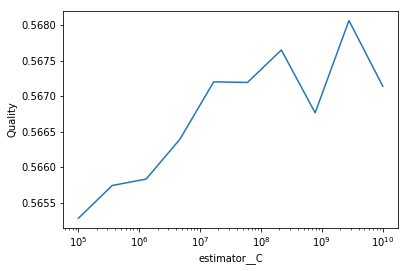

In [34]:
plot_grid_searcher_results(grid_searcher, log_scale=True)

In [48]:
_time = time.time()
clf = OneVsRestClassifier(LinearRegression(), n_jobs=6)
clf.fit(trainFeatures, trainCategory)
print('Fit time: ', time.time() - _time)

KeyboardInterrupt: 

### Words

In [54]:
words = {}
for i in trainTextsToken:
    for j in i:
        if j in words:
            words[j] += 1
        else:
            words[j] = 1

for i in testTextsToken:
    for j in i:
        if j in words:
            words[j] += 1
        else:
            words[j] = 1

In [55]:
items = {y:x for x,y in words.items()}

In [56]:
col = np.array(list(items.keys()))
col.sort()
col = col[::-1]

In [63]:
for i in col:
    if not bool(re.search(r'\d', items[i])) and bool(re.search(r'[a-z]', items[i])):
        print(items[i])

ru
mail
the
com
http
amp
of
id
array
in
by
to
is
dji
vip
info
copyright
pro
facebook
paintboy
de
for
alize
iblock
level
parent
depth
item
football
section
phantom
you
league
premier
fc
ua
fi
type
org
twitter
baby
time
link
text
javascript
re
la
jpg
shishas
black
no
faq
txt
youtube
motorola
iphone
hd
rtf
element
picture
cotton
comments
vertex
blog
permission
additional
batik
child
params
bresser
vector
ipad
arptemplate
topas
belmetal
saint
hubsan
rus
concertinfo
image
lt
posted
midland
jun
phobia
qrz
carpediem
krafts
string
barclays
ukraine
et
pуб
room
rows
goods
anya
dxnews
jewish
coollib
lock
aug
chiffr
dictionary
td
planches
gig
msimagelist
iglanew
sharelink
tis
titre
uploaded
usg
infokam
valign
euroriding
kingsland
waldhausen
equiline
vinham
ruметро
medwell
umbria
grunja
cavalleria
kruker
ustyles
uncategorizedдобавить
gurkin
dancesportglobal
strv


In [56]:
for i in col[:100]:
    if items[i] not in delWords:
        print(items[i])

2017
рубль
год
это
00
как
быть
сайт
книга
или
10
день
06
купить
июнь
москва
человек
один
мочь
ru
дробный
20
12
2016
время
магазин
новость
цена
гороскоп
но
15
хороший
11
новый
25
то
19
17
ребёнок
большой
работа
читать
30
билет
набор
16
товар
18
мир
корзина
знакомство
22
можно
14
только
21
жизнь
так
автор
23
театр
дом
игра
если
13
детский
вышивка
заказ
город
имя
главный
интернет
карта
добавить


In [144]:
print(set([items[i] if not bool(re.search(r'\d', items[i])) else None for i in col[200:300]]))

{'price', 'gradient', 'media', 'самый', 'ffffff', 'знакомство', 'дом', 'referrer', 'этот', 'repeat', 'другой', 'php', 'vk', 'цена', 'max', 'товар', 'читать', 'mail', 'nav', 'random', 'float', 'alt', 'автор', 'email', 'можно', 'если', 'мир', 'site', 'новость', 'hash', 'linear', 'time', 'так', 'новый', 'ребёнок', 'корзина', 'director', 'театр', 'math', 'and', 'то', 'undefined', 'большой', 'protocol', 'fa', 'ajax', 'country', 'table', 'билет', 'try', 'гороскоп', 'object', 'min', 'catch', 'the', 'target', 'shadow', 'хороший', 'getelementbyid', 'images', 'bitrix', 'counter', 'line', 'только', 'ya', 'просмотр', 'вышивка', 'но', 'product', 'to', 'жизнь', 'addeventlistener', 'page', 'core', 'работа', 'набор', None, 'transform', 'grid', 'ua', 'family', 'weight', 'solid'}


In [146]:
delWords = ['div', 'js', 'td', 'document', 'color', 'url', 'span', 'li', 'true', 'screen', 'text',\
            'type', 'com', 'jpg', 'group', 'value', 'block', 'vc', 'img', 'style', 'right', 'width',\
            'border', 'new', 'src', 'content', 'http', 'hover', 'font', 'this', 'none', 'ru', 'background',\
            'false', 'var', 'return', 'null', 'menu', 'if', 'left', 'height', 'margin', 'title', 'https',\
            'important', 'image', 'function', 'padding', 'bottom', 'class', 'name', 'param', 'card', 'size',\
            'window', 'top', 'script', 'push', 'data', 'ul', 'href', 'id', 'display', 'location', 'css', 'async',\
            'tta', 'all', 'body', 'png', 'escape', 'html', 'parentnode', 'input', 'index', 'button', 'jquery',\
            'opera', 'event', 'position', 'rgba', 'link', 'ga', 'main', 'metrika', 'btn', 'show', 'container',\
            'form', 'header', 'center', 'javascript', 'webkit', 'search', 'typeof', 'box', 'www', 'click',\
            'radius', 'length', 'getelementsbytagname', 'date', 'no', 'insertbefore', 'before', 'colordepth',\
            'else', 'icon', 'write', 'post', 'for', 'wp', 'net', 'in', 'active', 'code', 'auto', 'item', 'align',\
            'widget', 'createelement', 'cat', 'bx', 'place',\
            'а', 'без', 'в', 'во', 'на', 'с', 'со', 'до', 'для', 'за', 'из', 'из-за', 'к', 'ко', 'между', 'у',\
            'над', 'надо', 'без', 'не', 'о', 'об', 'обо', 'от', 'перед', 'по', 'под', 'подо', 'после', 'пред',\
            'при', 'про']